In [66]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

In [67]:
titanic = pd.read_csv(r'titanic3.csv', sep=';')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [68]:
titanic.shape

(1310, 14)

In [69]:
titanic.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

**1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных.**

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|pclass        |класс билета  |1 - 1 класс; 2 -  2 класс; 3 -  3 класс |
|survived| выживание| 0 - Нет ;1 - Да|
|name|имя|любой|
|sex|пол|female - женский, male - мужской|
|age|возраст|любой числовой|
|sibsp|число братьев, сестер, супругов на борту|любой числовой|
|parch|число родителей, детей на ботру|любой числовой|
|fare|цена билета(британский фунт)|любой числовой|
|ticket|номер билета|любой|
|cabin|номер каюты|любой|
|embarked|порт погрузки|C = Cherbourg, Q = Queenstown, S = Southampton|
|boat|номер спасательной шлюпки|любой|
|body|идентификационный номер тела|любой|
|home.dest|Дом/Назначение|любой|    

Лишние признаки: body, boat, ticket, cabin, home.dest, name

In [70]:
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
titanic.drop(list_to_drop, axis=1, inplace=True)
titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


In [71]:
titanic.count()

pclass      1309
survived    1309
sex         1309
age         1046
sibsp       1309
parch       1309
fare        1308
embarked    1307
dtype: int64

**2. Удалите дубликаты строк в наборе данных.**

In [72]:
titanic = titanic.drop_duplicates()
titanic.shape

(1115, 8)

In [73]:
titanic.count()

pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

**3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)**

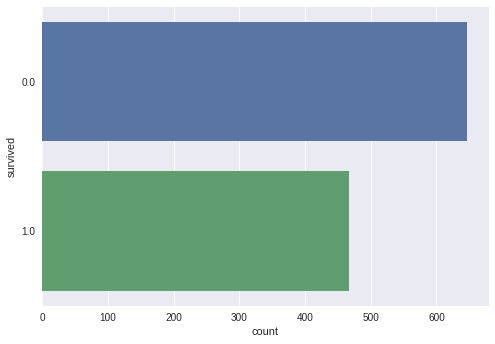

In [74]:
sns.countplot(data=titanic, y='survived')
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.    
Будем использовать ROC-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы и их размеры выборки отличаются друг от друга несущественно (не на порядок)

**4. Выполните масштабирование количественных признаков.**

In [75]:
# выделим категориальные и количественные признаки
numerical_columns = [i for i in titanic.columns if titanic[i].dtype.name != 'object']
categorial_columns = [i for i in titanic.columns if titanic[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['pclass', 'survived', 'sibsp', 'parch']
categorial:  ['sex', 'age', 'fare', 'embarked']


age и fare по форме должны быть числовыми

In [76]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj

titanic['age'] = titanic['age'].apply(lambda x: cast(x))
titanic['fare'] = titanic['fare'].apply(lambda x: cast(x))

pclass должен относиться к категориальным признакам, а не количественным

In [77]:
titanic['pclass'] = titanic['pclass'].apply(lambda x: str(x))

numerical_columns = [i for i in titanic.columns if titanic[i].dtype.name != 'object']
categorial_columns = [i for i in titanic.columns if titanic[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


sklearn не работает с пустыми значениями, поэтому заполним/выбросим их

In [78]:
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic = titanic.dropna().reset_index(drop=True)
titanic.count()

pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

In [79]:
# нормализация
scaler = MinMaxScaler()
titanic[numerical_columns] = scaler.fit_transform(titanic[numerical_columns])

titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


**5. Выполните замену категориальных признаков.**

In [80]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', titanic[i].unique())

pclass :  ['1.0' '2.0' '3.0']
sex :  ['female' 'male']
embarked :  ['S' 'C' 'Q']


In [81]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(titanic[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(titanic[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(titanic[col].unique()):
        titanic[col] = titanic[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
nonbinary = pd.get_dummies(titanic[nonbinary_columns])
titanic.drop(nonbinary_columns, axis=1, inplace=True)
titanic = pd.concat([nonbinary, titanic] , axis=1)

print(titanic.shape)
titanic.head()

(1111, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


**6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)**

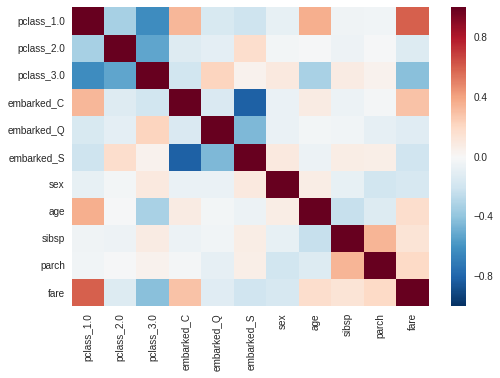

In [82]:
corr = titanic.drop('survived', axis=1).corr()
sns.heatmap(corr)
plt.show()

In [84]:
corr

,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,sex,age,sibsp,parch,fare
pclass_1.0,1.000000,-0.328892,-0.627709,0.334279,-0.159778,-0.208995,-0.085627,0.366644,-0.042350,-0.038106,0.596881
pclass_2.0,-0.328892,1.000000,-0.528693,-0.132455,-0.096509,0.176612,-0.027632,-0.008998,-0.049192,-0.010906,-0.139155
pclass_3.0,-0.627709,-0.528693,1.000000,-0.191272,0.223164,0.042266,0.099741,-0.322128,0.078614,0.043240,-0.421780
embarked_C,0.334279,-0.132455,-0.191272,1.000000,-0.155036,-0.814749,-0.069667,0.079976,-0.060418,-0.019729,0.294691
embarked_Q,-0.159778,-0.096509,0.223164,-0.155036,1.000000,-0.446488,-0.065294,-0.029736,-0.031391,-0.087189,-0.120226
embarked_S,-0.208995,0.176612,0.042266,-0.814749,-0.446488,1.000000,0.101422,-0.054985,0.073147,0.069042,-0.196352
sex,-0.085627,-0.027632,0.099741,-0.069667,-0.065294,0.101422,1.000000,0.071614,-0.079152,-0.195243,-0.166315
age,0.366644,-0.008998,-0.322128,0.079976,-0.029736,-0.054985,0.071614,1.000000,-0.227817,-0.136196,0.172287
sibsp,-0.042350,-0.049192,0.078614,-0.060418,-0.031391,0.073147,-0.079152,-0.227817,1.000000,0.342894,0.137128
parch,-0.038106,-0.010906,0.043240,-0.019729,-0.087189,0.069042,-0.195243,-0.136196,0.342894,1.000000,0.196667


Видна сильная отрицательная зависимость между параметрами, которые были выделены dummy-кодированием, что естественно. Слабая зависимость между parch и sibsp, что тоже нормально. Средняя зависимость между fate(цена билета) и уровнем класса говорит, что параметры близки друг другу, и есть избыточные данные.

**7. Заполните пропущенные значения в данных.**

In [85]:
titanic.shape

(1111, 12)

In [86]:
titanic.count()

pclass_1.0    1111
pclass_2.0    1111
pclass_3.0    1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

**8. Решите поставленную задачу классификации в соответствии с заданием.**

- классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов)
- логический классификатор (бинарное решающее дерево)

In [89]:
X, y = titanic.drop('survived', axis=1), titanic['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(777, 11)
(334, 11)


In [91]:
rnc = RadiusNeighborsClassifier(outlier_label=1)
params = {'radius': np.arange(0, 5, 0.25)}
rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)
best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)
rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.7786357786357786 	 at radius: 0.5
test score:  0.775449101796


In [92]:
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,12))}
dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)
best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.788931788931789 	 at features number: 8 	 at depth: 5
test score:  0.787425149701


Для построения ROC и PR кривых необходимо получить вероятности принадлежности примера к одному из классов, а затем варьировать границу выбора класса. Вероятности можно получить с помощью метода predict_proba. Но, к сожалению, этот метод отсутствует у классификатора RadiusNeighborsClassifier. Остается только попытаться написать его аналог.

In [93]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),2), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas


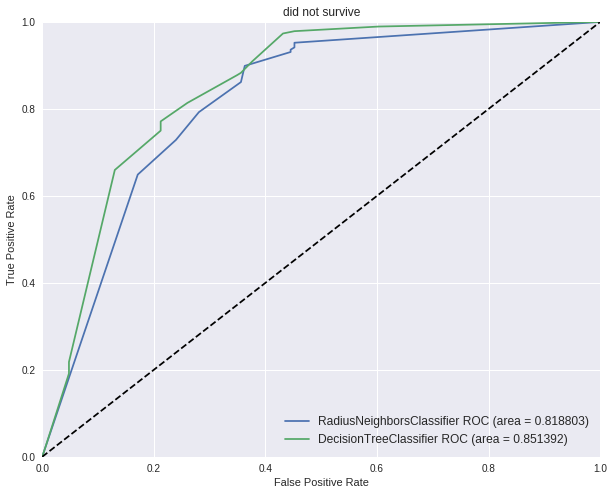

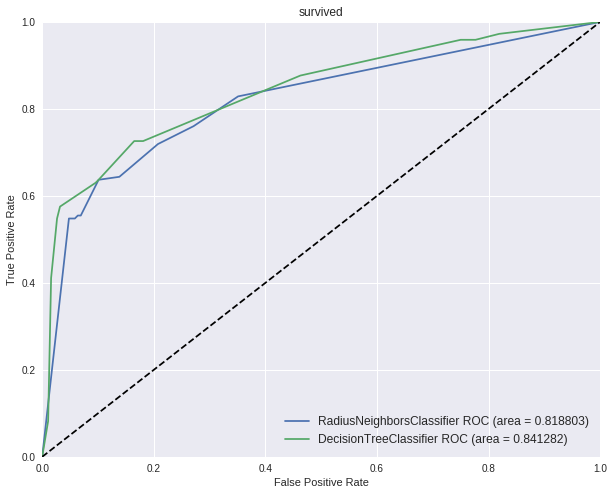

In [94]:
# ROC график K соседей и решающего дерева

# died
plt.figure(figsize=(10,8))
# K
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test, probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 
# tree
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# chart
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('did not survive')
plt.show()

# surv
plt.figure(figsize=(10,8))
# K
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, probas_mrnc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 
# tree
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_dtc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# chart
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

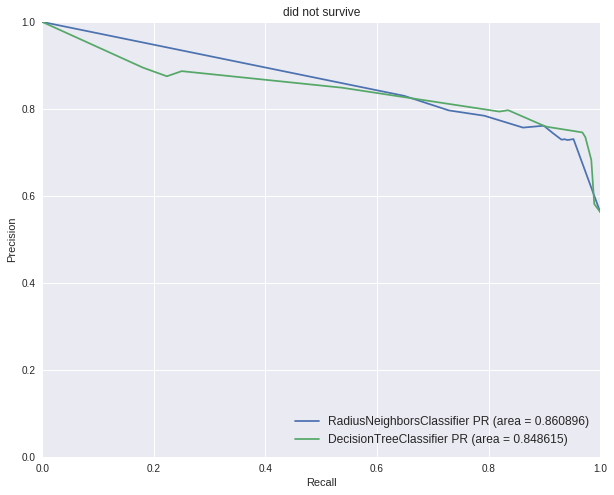

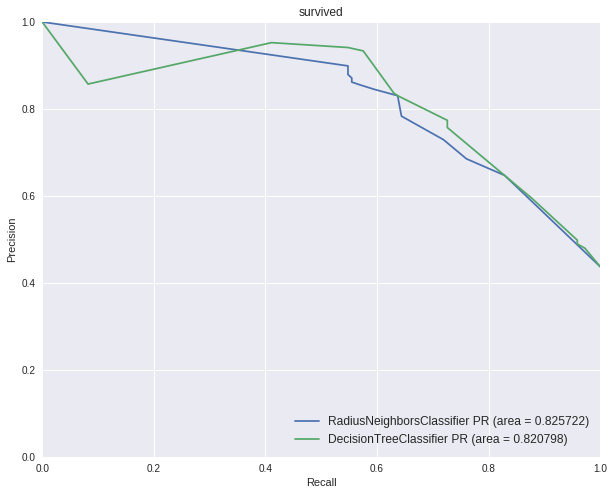

In [95]:
# PR график K соседей и решающего дерева

# died
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test_invers,probas_mrnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# tree
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# chart
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('did not survive')
plt.show()

# surv
plt.figure(figsize=(10,8))
# K 
precision, recall, thresholds = precision_recall_curve(y_test, probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test,probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# tree
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# chart
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('survived')
plt.show()

**9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.**

Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели качества относительно PR и ROC кривых. В целом, данные классификаторы правильно решают задачу предсказания класса с вероятностью 0.8~0.85, что не слишком точно, но и далеко от случайного - 0.5 (т.к. классов всего 2). Поэтому задача классификации была решена, но по-прежнему есть пути улучшить результаты: подобрать более подходящий под задачу классификатор,  осуществить несколько иной подход к подготовке данных в соответсвие с выбранным классификатором.